In [1]:
import tike
import dxchange
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tike.constants import *
import pickle
import lzma

# Setup Experiment

## Probe

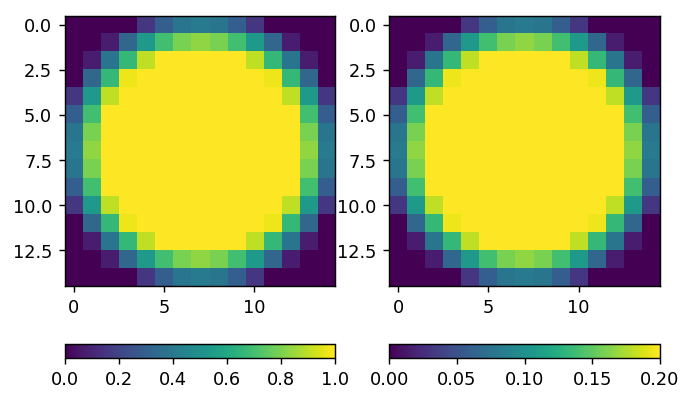

0j (0.980067+0.198669j)


In [2]:
# Create a probe.
pw = 15 # probe width
energy = 5 # keV probe energy
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
tike.plot_phase(probe)

## Object

In [3]:
# Load a 3D object.
with lzma.open('../tests/data/nalm256.pickle.lzma', 'rb') as file:
    obj = pickle.load(file)
obj.shape

(256, 256, 256)

In [4]:
np.min(obj), np.max(obj)

(0j, (0.00013467284535695345+2.7094510719149577e-05j))

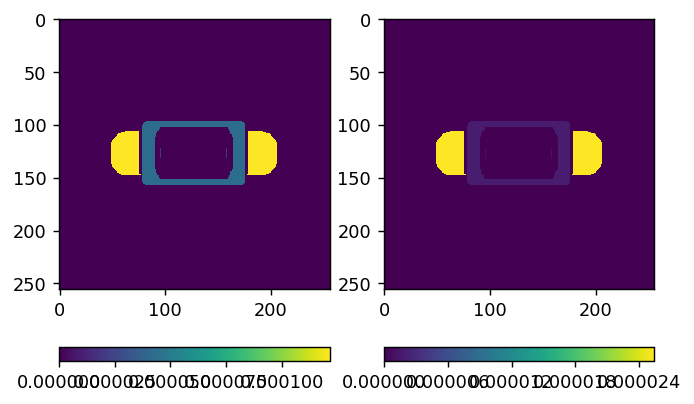

In [5]:
# Assemble the object.
voxelsize = 1e-7
tike.plot_complex(obj[128])

## Trajectory

In [6]:
N_ANGLE = int(np.pi / 2 * obj.shape[2])
theta = np.linspace(0, np.pi, N_ANGLE, endpoint=False)
theta.shape

(402,)

In [ ]:
none, v, h = np.meshgrid(np.arange(N_ANGLE),
                   np.arange(0, obj.shape[0]-pw, pw//2,),
                   np.arange(0, obj.shape[2]-pw, pw//2,),
                   indexing='ij')
print(h.shape)

(402, 35, 35)


# Simulate data

In [ ]:
line_integrals = tike.tomo.forward(obj=obj, theta=theta) * voxelsize
line_integrals.shape

In [ ]:
tike.plot_complex(line_integrals[0])

In [ ]:
psi = np.exp(1j * wavenumber(energy) * line_integrals)

In [ ]:
tike.plot_phase(psi[0])

In [ ]:
data = list()
for view in range(len(psi)):
    data.append(tike.ptycho.simulate(data_shape=np.ones(2, dtype=int) * pw * 3,
                                     probe=probe, v=v[view], h=h[view],
                                     psi=psi[view])
               )

In [ ]:
len(data), data[0].shape

In [ ]:
# dxchange.write_tiff(data.astype('float32'),
#                     fname='data/detector-amplitude.tiff',
#                     overwrite=True)

In [ ]:
# data = dxchange.read_tiff(fname='data/detector-amplitude.tiff')

In [ ]:
plt.imshow(np.fft.fftshift(np.log(data[16][16])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

In [ ]:
# init = np.random.rand(*obj.shape, 2).view(complex)[..., 0]
recon = np.zeros(obj.shape, dtype=complex)
recon.shape

In [ ]:
recon = tike.admm(obj=recon, voxelsize=voxelsize,
             data=data,
             probe=probe, theta=theta, v=v, h=h, energy=energy,
             niter=1,
             rho=0.5, gamma=0.25,
            )

In [ ]:
tike.plot_complex(recon[pw])